# LYFT DATA CHALLENGE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import *
import seaborn as sn
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import time
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import BarycentricInterpolator

In [3]:
drivers = pd.read_csv('driver_ids.csv')
rideID = pd.read_csv('ride_ids.csv')
ridetime = pd.read_csv('ride_timestamps.csv')

# GOALS

After exploring and analyzing the data, please:
 
#### 1.     Recommend a Driver's Lifetime Value (i.e., the value of a driver to Lyft over the entire projected lifetime of a driver).
- Most obvious is the revenue that the driver has accumulated normalized by time
- Shorter rides vs longer rides value
- Which time are they active? Are more drivers getting more during late or early or busienss?
Why 
 
#### 2. 	Please answer the following questions:
 
    a) What are the main factors that affect a driver's lifetime value?
 
    b) What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?
 
    c) Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?
 
    d) What actionable recommendations are there for the business?
 
#### 3.     Prepare and submit a writeup of your findings for consumption by a cross-functional audience.
***

# Column Elements

### Drivers:
- #### driver_id: 
        Unique identifier for a driver
- #### driver_onboard_date : 
        Date on which driver was on-boarded

### RideID:
- driver_id = Unique identifier for a driver
 
- ride_id = Unique identifier for a ride that was completed by the driver
 
- ride_distance = Ride distance in meters
 
- ride_duration = Ride duration in seconds
 
- ride_prime_time = Prime Time applied on the ride

### RideTime:
- ride_id = Unique identifier for a ride
 
- event = event describes the type of event (see below)
 
- timestamp = Time of event

***
 
#### EVENT TYPES:
 
- #### requested_at : 
        passenger requested a ride
 
- #### accepted_at :
        driver accepted a passenger request
 
- #### arrived_at : 
        driver arrived at pickup point
 
- #### picked_up_at : 
        driver picked up the passenger
 
- #### dropped_off_at : 
        driver dropped off a passenger at destination

 


 



 
 
 

 

 

 



***
# Assumptions:
- All rides in the data set occurred in San Francisco
 
- All timestamps in the data set are in UTC

## Rates:

- Base Fare : $2.00 

- Cost per Mile : $1.15

- Cost per Minute : $0.22 

- Service Fee : $1.75

- Minimum Fare : $5.00

- Maximum Fare : $400.00
 



***

 

 

 

 


In [4]:
print(len(drivers) == drivers.driver_id.nunique())
drivers.driver_onboard_date = pd.to_datetime(drivers.driver_onboard_date)
drivers.head()

True


,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29
1,007f0389f9c7b03ef97098422f902e62,2016-03-29
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23
4,01674381af7edd264113d4e6ed55ecda,2016-04-29


In [5]:
rideID.head(5)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [6]:
ridetime.timestamp = pd.to_datetime(ridetime.timestamp)

In [7]:
ridetime.head(5)

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


Adding fare & determining timestamp for each ride.

In [8]:
rideID['fare'] = rideID.apply(value_of_ride, axis = 1)
rideID = rideID.merge(ridetime[ridetime['event'] == 'arrived_at'][['ride_id','timestamp']], 
                      on = "ride_id", 
                      how = "left")

In [9]:
rideID.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,fare,timestamp
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.000000,2016-04-23 02:16:36
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,5.368741,2016-03-29 19:03:57
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,5.000000,2016-06-21 12:01:32
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,58.889055,2016-05-19 09:18:20
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,5.958150,2016-04-20 22:07:03


In [10]:
mapping = {}
for driver in drivers.driver_id:
    sdf = rideID[rideID.driver_id == driver]
    mapping[driver] = sdf.timestamp.max()

In [11]:
drivers['latest_ride'] = drivers.driver_id.replace(mapping)

In [12]:
drivers['time_on_board'] = drivers.latest_ride - drivers.driver_onboard_date 

In [13]:
drivers_with_rides = drivers.dropna()

In [14]:
driver_grouping = rideID.groupby("driver_id")

In [15]:
drivers_with_rides = drivers_with_rides.merge(
    driver_grouping.sum().rename(columns = {'ride_distance': 'sum_distance', 
                                            'ride_duration':'sum_duration',
                                            'ride_prime_time': 'sum_prime_time',
                                            'fare': 'fare_sum'}).reset_index(),
    on = "driver_id",
    how = "left").dropna()

In [16]:
drivers_with_rides = drivers_with_rides.merge(
    driver_grouping.std().reset_index()[['driver_id','ride_distance','ride_duration','fare']].rename(columns = {'ride_distance': 'ride_distance_sd',
                                                     'ride_duration': 'ride_duration_sd',
                                                     'fare': 'fare_sd'}),
    on = "driver_id",
    how = "left").dropna()

In [17]:
drivers_with_rides = drivers_with_rides.merge(
    driver_grouping.count().reset_index()[['driver_id','ride_id']].rename(columns = {'ride_id':'count'}),
    on = "driver_id",
    how = "left").dropna()

In [18]:
def get_day_count(sdf):
    y = [x.weekday_name for x in sdf.timestamp]
    counts = Counter(y)
    df2 = pd.DataFrame.from_dict(counts, orient = "index")
    df2[0] = df2[0] / len(y)
    days_per_week = len(df2[0] > 0)
    df2 = df2.T
    df2['days_per_week'] = days_per_week
    return df2

In [19]:
drivers_with_rides = drivers_with_rides.merge(
    driver_grouping.apply(get_day_count).fillna(0).reset_index().drop(columns = ['level_1', np.nan]),
    on = "driver_id",
    how = "left")

/Users/udaisingh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  


In [20]:
drivers_with_rides['days_on_board'] = (drivers_with_rides.time_on_board.apply(lambda x : x.days) 
                                       + drivers_with_rides.time_on_board.apply(lambda x : x.seconds) / (60 * 60 * 24))

In [21]:
def nunique_days(sdf):
    return pd.Series([x.date() for x in sdf.timestamp]).nunique()

In [22]:
drivers_with_rides = drivers_with_rides.merge(driver_grouping.apply(nunique_days).to_frame().reset_index().rename(
    columns = {0:"nunique_days"}),
                                              how = "left",
                                              on = "driver_id")

In [23]:
drivers_with_rides['fare_per_day'] = drivers_with_rides['fare_sum'] / drivers_with_rides['nunique_days']
drivers_with_rides['distance_per_day'] = drivers_with_rides['sum_distance'] / drivers_with_rides['nunique_days'] 
drivers_with_rides['duration_per_day'] = drivers_with_rides['sum_duration'] / drivers_with_rides['nunique_days'] 
drivers_with_rides['count_per_day'] = drivers_with_rides['count'] / drivers_with_rides['nunique_days']
drivers_with_rides['prime_time_per_day'] = drivers_with_rides['sum_prime_time'] / drivers_with_rides['nunique_days'] 

In [24]:
def num_after_time(sdf):
    result = []
    for x in sdf.timestamp:
        if not pd.isnull(x):
            h = x.time().hour
            result.append(h)
    return len([t for t in result if t > 20])

In [25]:
drivers_with_rides = drivers_with_rides.merge(driver_grouping.apply(num_after_time).to_frame().reset_index().rename(
    columns = {0:"evening_rides"}),
                                              how = "left",
                                              on = "driver_id")

In [26]:
def num_after_time(sdf):
    result = []
    for x in sdf.timestamp:
        if not pd.isnull(x):
            h = x.time().hour
            result.append(h)
    return len([t for t in result if t < 9])

In [27]:
drivers_with_rides = drivers_with_rides.merge(driver_grouping.apply(num_after_time).to_frame().reset_index().rename(
    columns = {0:"morning_rides"}),
                                              how = "left",
                                              on = "driver_id")

In [28]:
drivers_with_rides['evening_percentage'] = drivers_with_rides.evening_rides / drivers_with_rides["count"]
drivers_with_rides['morning_percentage'] = drivers_with_rides.morning_rides / drivers_with_rides["count"]

### Removing Outliers

In [29]:
drivers_with_rides = drivers_with_rides[drivers_with_rides.ride_distance_sd < 80000]
drivers_with_rides = drivers_with_rides[drivers_with_rides.count_per_day < 17]
drivers_with_rides = drivers_with_rides[drivers_with_rides.duration_per_day < 15000]

In [30]:
drivers_with_rides.head()

,driver_id,driver_onboard_date,latest_ride,time_on_board,sum_distance,sum_duration,sum_prime_time,fare_sum,ride_distance_sd,ride_duration_sd,...,nunique_days,fare_per_day,distance_per_day,duration_per_day,count_per_day,prime_time_per_day,evening_rides,morning_rides,evening_percentage,morning_percentage
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,2016-06-23 10:08:03,86 days 10:08:03,1740287,221238,5375,2264.221685,9429.618349,501.906723,...,56,40.432530,31076.553571,3950.678571,4.946429,95.982143,65,68,0.234657,0.245487
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,2016-06-22 13:19:23,85 days 13:19:23,117531,20497,625,185.492070,2080.321776,267.462698,...,12,15.457672,9794.250000,1708.083333,2.583333,52.083333,11,0,0.354839,0.000000
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,2016-06-12 20:23:28,68 days 20:23:28,269653,29205,675,325.073445,14857.037209,743.742073,...,12,27.089454,22471.083333,2433.750000,2.833333,56.250000,3,3,0.088235,0.088235
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23,2016-06-26 10:24:51,64 days 10:24:51,1471239,174521,2050,1803.590978,6661.567256,547.786466,...,40,45.089774,36780.975000,4363.025000,4.775000,51.250000,44,100,0.230366,0.523560
4,01674381af7edd264113d4e6ed55ecda,2016-04-29,2016-06-24 13:07:25,56 days 13:07:25,3123644,357443,4700,3754.071987,9603.313564,552.958426,...,40,93.851800,78091.100000,8936.075000,9.375000,117.500000,0,129,0.000000,0.344000


## Plotting

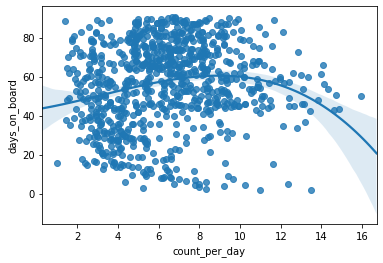

In [31]:
sn.regplot(x = "count_per_day", y = "days_on_board", data = drivers_with_rides, order = 3, x_bins = None)

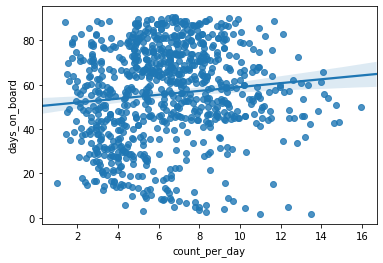

In [32]:
sn.regplot(x = "count_per_day", y = "days_on_board", data = drivers_with_rides, order = 1, x_bins = None)

This shows that there is a systemic problem with the data that inhibits us from applying any statistical models. There seems to be 2 generally distinct groups within the data.

Group 1 is the people that that drivers for a long time (days_on_board), but they tend do few rides. On the other hand, there is a second groups that seems to be a blob of data. This seems to be reflected in the plots below.

Our analysis of this is that there are 2 types of drivers: (1) drivers that have a lot of rides (aka common drivers), and (2) drivers with few rides (part-time drivers).

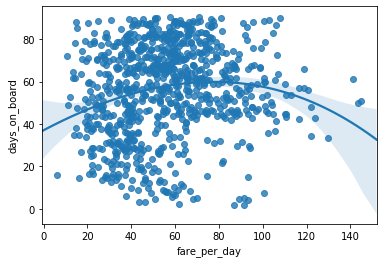

In [33]:
sn.regplot(x = "fare_per_day", y = "days_on_board", data = drivers_with_rides, x_bins = None, order = 3)

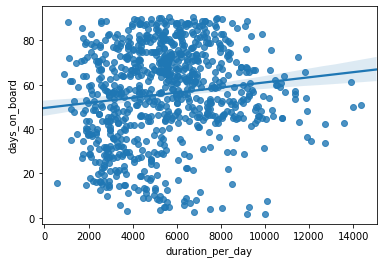

In [34]:
sn.regplot(x = "duration_per_day", y = "days_on_board", data = drivers_with_rides, x_bins = None, order = 1)

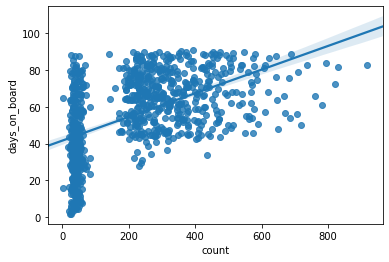

In [35]:
sn.regplot(x = "count", y = "days_on_board", data = drivers_with_rides, x_bins = None, order = 1)

Our conclusion from this is that there are 2 major groups drivers, and we should look at them seperately to get the most reliable results from our analysis. 

This is analogous to viewing the employees of a company as being full-time and part-time. The productivity and characteristics of these 2 groups are likely to be highly different. Therefore, the most reasonable thing for us to would be to group them into 2 seperate analyses.

### Variance Analysis

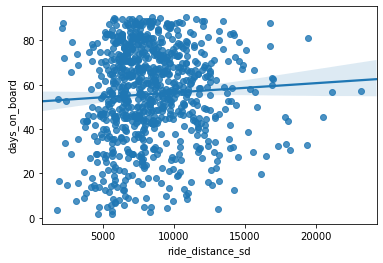

In [36]:
sn.regplot(x = "ride_distance_sd", y = "days_on_board", data = drivers_with_rides, x_bins = None, order = 1)

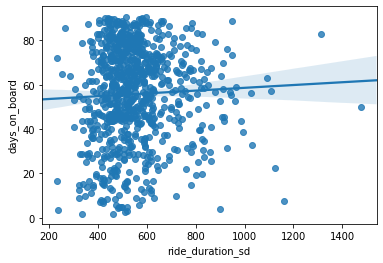

In [37]:
sn.regplot(x = "ride_duration_sd", y = "days_on_board", data = drivers_with_rides, x_bins = None, order = 1)

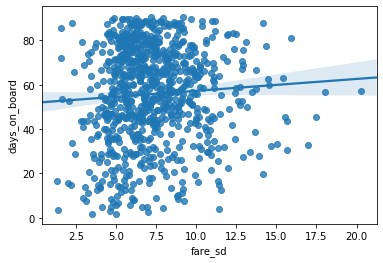

In [38]:
sn.regplot(x = "fare_sd", y = "days_on_board", data = drivers_with_rides, x_bins = None, order = 1)

In [39]:
drivers_with_rides[drivers_with_rides['count'] > 100].shape

(498, 31)

When looking at the variances, there seems to just a blob of data that does not visually show any reasonable difference. This is not to say that the variational of fares,ride_duration, etc. do not have any meaningful information.

However, visually, there does not seem to be any discernable pattern. Therefore, because no pattern seems to be visually apparent and the dataset is relatively small (500 drivers with at least 1 ride), we determined to ignore the variance aspect of the data.

### Clustering

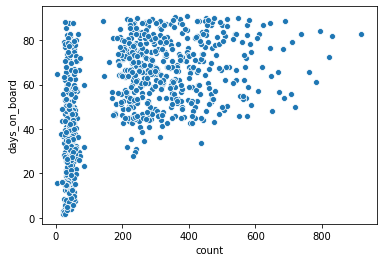

In [40]:
sn.scatterplot(x = "count", y = "days_on_board", data = drivers_with_rides)
plt.savefig("count_vs_day_on_job.png", dpi = 220)

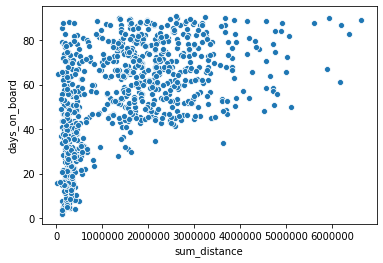

In [41]:
sn.scatterplot(x = "sum_distance", y = "days_on_board", data = drivers_with_rides)
plt.savefig("count_vs_sum_distance.png", dpi = 220)

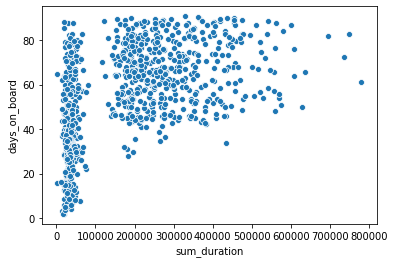

In [42]:
sn.scatterplot(x = "sum_duration", y = "days_on_board", data = drivers_with_rides)
plt.savefig("count_vs_sum_duration.png", dpi = 220)

In [43]:
model1 = KMeans(n_clusters= 2, random_state= 500).fit(drivers_with_rides[['count', 'days_on_board']])
model2 = AgglomerativeClustering(n_clusters= 2).fit(drivers_with_rides[['count', 'days_on_board']])

In [44]:
drivers_with_rides['clusters1'] = model1.labels_
drivers_with_rides['clusters2'] = model2.labels_

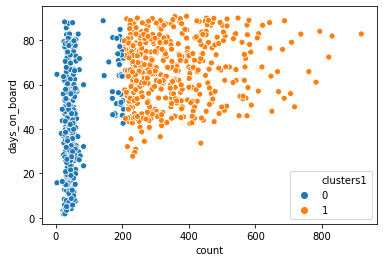

In [45]:
sn.scatterplot(x = "count", y = "days_on_board", data = drivers_with_rides, hue= "clusters1")

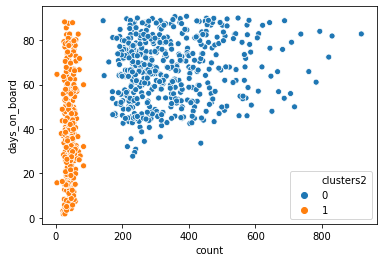

In [46]:
sn.scatterplot(x = "count", y = "days_on_board", data = drivers_with_rides, hue= "clusters2")
plt.savefig("clustering.png", dpi = 220)

It is fairly clear that the agglomerative clustering algorithm does a good job with with the clustering; therefore, we are going to use those clusters to divide the data.

In [47]:
drivers_with_rides = drivers_with_rides.drop(columns=["clusters1"])

In [48]:
part_time_drivers = drivers_with_rides[drivers_with_rides.clusters2 == 1]
full_time_drivers = drivers_with_rides[drivers_with_rides.clusters2 == 0]

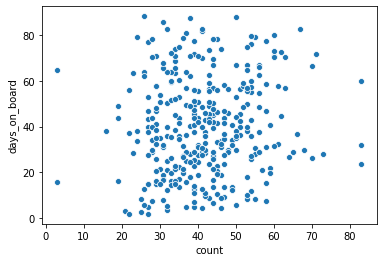

In [49]:
sn.scatterplot(x = "count", y = "days_on_board", data = part_time_drivers)

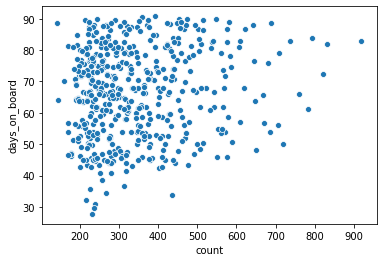

In [50]:
sn.scatterplot(x = "count", y = "days_on_board", data = full_time_drivers)

This shows that when seperating the 2 "types" of drivers, the data goes from being very bifercated to being more reasonable to view. Also, we hope that this makes the analysis easier to perform. 

## Analysis: promote more days worked

In [51]:
part_time_drivers.T

,1,2,6,10,12,16,17,19,20,22,...,814,815,816,818,819,824,826,827,831,834
driver_id,007f0389f9c7b03ef97098422f902e62,011e5c5dfc5c2c92501b8b24d47509bc,021e5cd15ef0bb3ec20a12af99e142b3,02e440f6c209206375833cef02e0cbae,039c5afbca8e03e4c18d9c8ea94140ac,0430df9a3eb327122c57ee3a64765000,04c4ffa5a385eab86fa7e422263d2999,052bba06c5fc0bdea4bc2f9cb92b37c7,059ed570673c2d15ca11dd6b3a25513b,05bad02e08c7f849e91dc1259da8b4ec,...,fac81ea6cbd540c89c7eee17e851a233,faebff3d5429ff2036c125a91df765c8,fb83fc6555a4f700fd92630d9fcb9cea,fba8372d56b91b1bff7b71d970b5af58,fbe0433e5b1a3db9dc9d6ed21efc6148,fd831ca1d79ae5c6fc3a679a22e5b8cf,fdbee494c73577d5b1266d1fec5c6c9a,fde60697758e68d617f471e49f65db75,fed19d671569afe8a2f9fa0953dd25ca,fff482c704d36a1afe8b8978d5486283
driver_onboard_date,2016-03-29 00:00:00,2016-04-05 00:00:00,2016-05-07 00:00:00,2016-03-31 00:00:00,2016-04-12 00:00:00,2016-04-05 00:00:00,2016-04-07 00:00:00,2016-04-15 00:00:00,2016-05-12 00:00:00,2016-05-12 00:00:00,...,2016-04-30 00:00:00,2016-03-28 00:00:00,2016-04-28 00:00:00,2016-04-01 00:00:00,2016-05-08 00:00:00,2016-05-07 00:00:00,2016-05-15 00:00:00,2016-04-25 00:00:00,2016-03-29 00:00:00,2016-04-08 00:00:00
latest_ride,2016-06-22 13:19:23,2016-06-12 20:23:28,2016-06-25 20:13:04,2016-05-18 08:26:29,2016-06-12 21:48:05,2016-04-13 21:05:22,2016-05-07 18:15:16,2016-06-20 18:08:55,2016-06-20 15:36:55,2016-06-12 02:17:06,...,2016-06-04 16:57:35,2016-04-25 21:23:30,2016-05-27 19:35:10,2016-05-30 22:27:49,2016-06-19 01:46:39,2016-05-23 08:49:54,2016-06-11 12:13:02,2016-04-30 01:49:58,2016-04-24 09:13:30,2016-05-12 16:14:39
time_on_board,85 days 13:19:23,68 days 20:23:28,49 days 20:13:04,48 days 08:26:29,61 days 21:48:05,8 days 21:05:22,30 days 18:15:16,66 days 18:08:55,39 days 15:36:55,31 days 02:17:06,...,35 days 16:57:35,28 days 21:23:30,29 days 19:35:10,59 days 22:27:49,42 days 01:46:39,16 days 08:49:54,27 days 12:13:02,5 days 01:49:58,26 days 09:13:30,34 days 16:14:39
sum_distance,117531,269653,257670,455475,245552,254250,466193,361814,313768,409881,...,258240,383306,547162,773471,460392,75963,381486,232892,252374,174394
sum_duration,20497,29205,50447,50021,30430,35639,57344,47006,32534,42498,...,33254,34368,49359,81849,41389,12619,34870,21904,28573,27693
sum_prime_time,625,675,1200,800,450,325,1450,850,325,775,...,450,75,875,800,1075,400,400,575,725,175
fare_sum,185.492,325.073,398.566,543.156,320.643,344.035,577.825,493.027,370.887,469.834,...,362.257,429.614,600.615,887.04,513.067,113.503,444.776,279.328,312.546,256.23
ride_distance_sd,2080.32,14857,4251.05,10547.6,7474.27,8017.53,8914.53,6499.18,12216,8514.09,...,5783.41,7698.36,11718.1,9025.57,12159.9,1863.02,9864.28,8366.05,10097.1,4585.44
ride_duration_sd,267.463,743.742,522.265,551.061,526.902,629.523,723.205,632.605,814.141,507.922,...,404.228,394.43,860.75,536.424,625.44,233.118,615.135,495.357,505.552,530.181


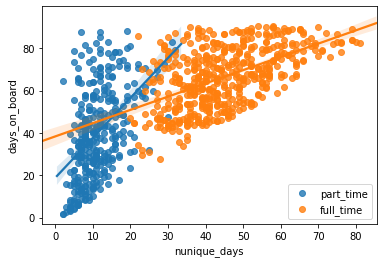

In [52]:
ax = sn.regplot(x = "nunique_days", y = "days_on_board", data = part_time_drivers, order = 1, label  = "part_time")
sn.regplot(x = "nunique_days", y = "days_on_board", data = full_time_drivers, order = 1, label = "full_time", ax = ax)
ax.legend()
plt.show()

There is a clear association here that working more unique days contributes to more days on board. This basically translates to the idea that if a driver is working "n" rides within a time frame, we would want to promote the driver to spread those over a larger amount of days to retain the driver.

This shows that even though the number of unique days is a sign of retention, it is a better predictor of retention for part-time workers. 

An actionable cause would be if we identify a driver as being "part-time", then we should promote them to work more # of days (maybe for less per day) in order to promote consistency (and thus retention).

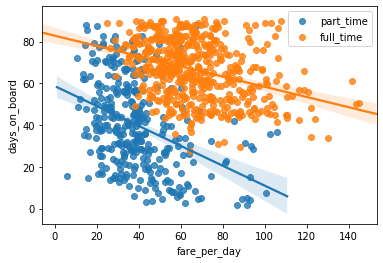

In [53]:
ax = sn.regplot(x = "fare_per_day", y = "days_on_board", data = part_time_drivers, order = 1, label  = "part_time")
sn.regplot(x = "fare_per_day", y = "days_on_board", data = full_time_drivers, order = 1, label = "full_time", ax = ax)
ax.legend()
plt.show()

## Analysis: Move more towards Full-Time

In [54]:
df2 = drivers_with_rides.groupby('clusters2').mean()


In [55]:
df2.days_on_board

clusters2
0    66.419736
1    40.000369
Name: days_on_board, dtype: float64

A clear lesson from this is that "full-time" drivers tend to stay board longer. Therefore, an actionable cause would be to promote people to become this "full-time" driver. if we want people on average to stay longer as drivers, a good cause to promote would be for riders to work more full-time.

## Analysis: Consistency over Productivity

In [56]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
#sns.jointplot(x, y, kind="reg", stat_func=r2)

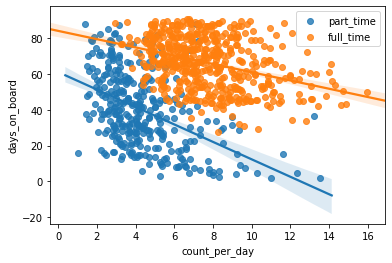

In [57]:
ax = sn.regplot(x = "count_per_day", y = "days_on_board", data = part_time_drivers, order = 1, label  = "part_time")
sn.regplot(x = "count_per_day", y = "days_on_board", data = full_time_drivers, order = 1, label = "full_time", ax = ax)
ax.legend()
#plt.show()
plt.savefig("count_per_day_vs_days_on_board.png", dpi = 220)

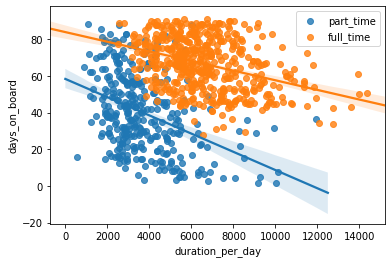

In [58]:
ax = sn.regplot(x = "duration_per_day", y = "days_on_board", data = part_time_drivers, order = 1, label  = "part_time")
sn.regplot(x = "duration_per_day", y = "days_on_board", data = full_time_drivers, order = 1, label = "full_time", ax = ax)
ax.legend()
#plt.show()
plt.savefig("duration_per_day_vs_days_on_board.png", dpi = 220)

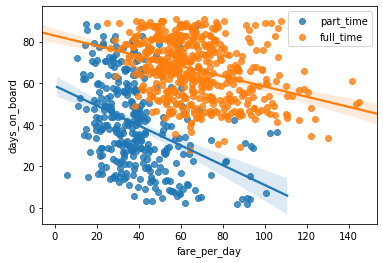

In [59]:
ax = sn.regplot(x = "fare_per_day", y = "days_on_board", data = part_time_drivers, order = 1, label  = "part_time")
sn.regplot(x = "fare_per_day", y = "days_on_board", data = full_time_drivers, order = 1, label = "full_time", ax = ax)
ax.legend()
#plt.show()
plt.savefig("fare_per_day_vs_days_on_board.png", dpi = 220)

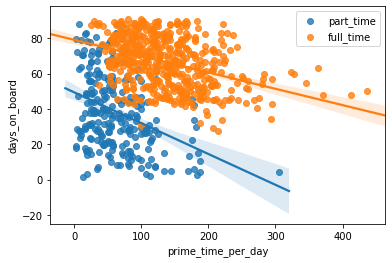

In [60]:
ax = sn.regplot(x = "prime_time_per_day", y = "days_on_board", 
                data = part_time_drivers[part_time_drivers.morning_percentage > 0], order = 1, label  = "part_time")
sn.regplot(x = "prime_time_per_day", y = "days_on_board", 
           data = full_time_drivers[full_time_drivers.morning_percentage > 0], order = 1, label = "full_time", ax = ax)
ax.legend()
plt.show()

The observation from this is that there is a commone theme that people that do have higher fares per day or higher duration of driving per day tend to have lower retention rates.

This would indicate that if we want to promote retention of drivers, we would want to promote drivers to "pace" themselves, such as promoting consistency (multiple days with potentially less rides) rather than going for less days of large amounts of work.

For example, we may want to promote drivers to not "overwork" themselves by rewarding consistency over simply productivity.

## Projecting Lifetime

A major question is the average projected lifetime of a driver. This is tough, because we do not have enough information to project far into the future. In our data, the most time between onboarding and leaving the is about 90 days. Also the dataset includes 900 drivers out of many thousands.

Therefore, projecting an average lifetime from this small dataset is likely not a good idea, but we can try it never-the-less.

In [61]:
part_time_projection = pd.DataFrame(columns = ["min_days", "count"])
for i in np.arange(0, int(part_time_drivers.days_on_board.max() + 10), 0.5):
    sum_val = (part_time_drivers.days_on_board > i).sum()
    datum = [float(i), float(sum_val)]
    part_time_projection.loc[len(part_time_projection)] = datum

In [62]:
full_time_projection = pd.DataFrame(columns = ["min_days", "count"])
for i in np.arange(0, int(full_time_drivers.days_on_board.max() + 10), 0.5):
    sum_val = (full_time_drivers.days_on_board > i).sum()
    datum = [float(i), float(sum_val)]
    full_time_projection.loc[len(full_time_projection)] = datum

In [63]:
all_time_projection = pd.DataFrame(columns = ["min_days", "count"])
for i in np.arange(0, int(drivers_with_rides.days_on_board.max() + 10), 0.5):
    sum_val = (drivers_with_rides.days_on_board > i).sum()
    datum = [float(i), float(sum_val)]
    all_time_projection.loc[len(all_time_projection)] = datum

In [64]:
full_time_projection['percentage'] = full_time_projection['count'] / full_time_projection['count'][0]
part_time_projection['percentage'] = part_time_projection['count'] / part_time_projection['count'][0]
all_time_projection['percentage'] = all_time_projection['count'] / all_time_projection['count'][0]

In [65]:
full_time_projection["inverted_percentage"] = 1 - full_time_projection.percentage
part_time_projection["inverted_percentage"] = 1 - part_time_projection.percentage
all_time_projection["inverted_percentage"] = 1 - all_time_projection.percentage

In [66]:
part_time_projection.head(10)

,min_days,count,percentage,inverted_percentage
0,0.0,335.0,1.000000,0.000000
1,0.5,335.0,1.000000,0.000000
2,1.0,335.0,1.000000,0.000000
3,1.5,335.0,1.000000,0.000000
4,2.0,333.0,0.994030,0.005970
5,2.5,333.0,0.994030,0.005970
6,3.0,332.0,0.991045,0.008955
7,3.5,330.0,0.985075,0.014925
8,4.0,330.0,0.985075,0.014925
9,4.5,329.0,0.982090,0.017910


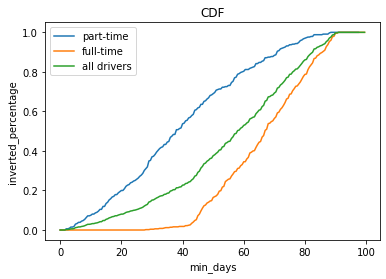

In [67]:
ax = sn.lineplot(x = "min_days", y = "inverted_percentage", data = part_time_projection, label = "part-time")
sn.lineplot(x = "min_days", y = "inverted_percentage", data = full_time_projection, label = "full-time", ax = ax)
sn.lineplot(x = "min_days", y = "inverted_percentage", data = all_time_projection, label = "all drivers", ax = ax)
plt.title("CDF")
plt.savefig("retention_cdf.png", dpi = 220)

We can think about this as representing the probability of a person staying a driver. In reality, the data continues up to about 90 days. However, this is flawed, because a person might still be a driver, but hasn't driven for the last few days. Therefore, I am using the cut_off of 70 days.

The goal is to fit a function to this data to represent the probability, such that f(X = x) represents the probability of being retained as a driver after x days.

Then, we can estimate the E[x] of this distribution using a monte_carlo method.

## Part-Time Expected Lifetime Analysis

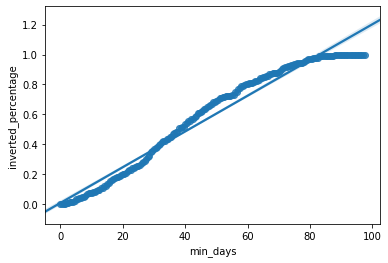

In [68]:
sn.regplot(x = "min_days", y = "inverted_percentage", data = part_time_projection, label = "part-time", order = 1)

This is clear that the CDF is best defined as a linear model.

In [86]:
dx = part_time_projection.min_days[1] - part_time_projection.min_days[0]
dx

0.5

In [87]:
y_value = np.diff(part_time_projection.inverted_percentage) / dx
y_value = y_value / np.sum(y_value)

In [88]:
np.sum(y_value)

1.0

In [89]:
estimated_value = np.sum(part_time_projection.min_days[1:] * y_value)
print("Estimated Time Spent as a driver: {}".format(estimated_value))

Estimated Time Spent as a driver: 40.223880597014926


In [90]:
pdf_estimate3 = pd.DataFrame(data = {"x" :part_time_projection.min_days[1:],
                                    "y": y_value}, columns= ["x", "y"])

## Full-Time Expected Lifetime Analysis

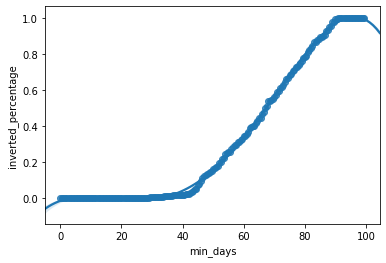

In [91]:
sn.regplot(x = "min_days", y = "inverted_percentage", data = full_time_projection, label = "part-time", order = 5)

In [92]:
dx = full_time_projection.min_days[1] - full_time_projection.min_days[0]
dx

0.5

In [93]:
y_value = np.diff(full_time_projection.inverted_percentage) / dx
y_value = y_value / np.sum(y_value)

In [94]:
np.sum(y_value)

1.0

In [95]:
estimated_value = np.sum(full_time_projection.min_days[1:] * y_value)
print("Estimated Time Spent as a driver: {}".format(estimated_value))

Estimated Time Spent as a driver: 66.63253012048193


In [96]:
pdf_estimate2 = pd.DataFrame(data = {"x" :full_time_projection.min_days[1:],
                                    "y": y_value}, columns= ["x", "y"])

## All Drivers Estimate

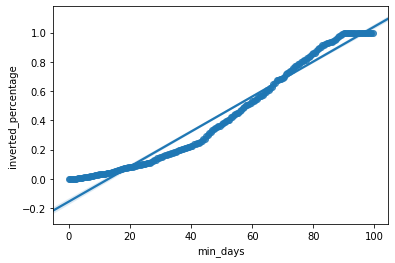

In [97]:
sn.regplot(x = "min_days", y = "inverted_percentage", data = all_time_projection, label = "all drivers", order = 1)

In [98]:
dx = all_time_projection.min_days[1] - all_time_projection.min_days[0]
dx

0.5

In [99]:
y_value = np.diff(all_time_projection.inverted_percentage) / dx
y_value = y_value / np.sum(y_value)

In [100]:
np.sum(y_value)

1.0

In [101]:
estimated_value = np.sum(full_time_projection.min_days[1:] * y_value)
print("Estimated Time Spent as a driver: {}".format(estimated_value))

Estimated Time Spent as a driver: 56.012004801920774


In [102]:
pdf_estimate1 = pd.DataFrame(data = {"x" :all_time_projection.min_days[1:],
                                    "y": y_value}, columns= ["x", "y"])

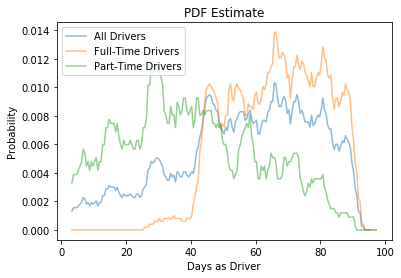

In [105]:
sn.lineplot(x = "x", y = "y", 
               data = pdf_estimate1.rolling(window = 10, win_type = "boxcar").mean()[10:], 
            label = "All Drivers", alpha = 0.5)
sn.lineplot(x = "x", y = "y", 
               data = pdf_estimate2.rolling(window = 10, win_type = "boxcar").mean()[10:], 
            label = "Full-Time Drivers", alpha = 0.5)
sn.lineplot(x = "x", y = "y", 
            data = pdf_estimate3.rolling(window = 10, win_type = "boxcar").mean()[10:], 
            label = "Part-Time Drivers",
           alpha = 0.5)
plt.title("PDF Estimate")
plt.xlabel("Days as Driver")
plt.ylabel("Probability")
plt.legend()
plt.savefig("estimate_pdf.png", dpi = 220)